# Utilities

In [72]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [73]:
def old_gillespie(G, initial_state, maxiter=1000):
    """
    Simulate a stochastic process using the Gillespie algorithm.
    
    Parameters
    ----------
    G : networkx DiGraph
        The reaction network.
        The nodes are the states of the system.
        The directed edges are the reactions, from the reactant to the product. Edges must have a 'rate' attribute.
    initial_state : networkx Node
        The initial state of the system.
    maxiter : int
        The maximum number of simulation iterations.
        
    Returns
    -------
    out : pandas DataFrame
        A dataframe containing the sojourn times spent in each state.
    """

    # Test if the initial state belongs to the graph
    if initial_state not in G.nodes():
        raise ValueError("The initial state does not belong to the graph.")

    # Initialilze the lists of states and sojourn times and initial state
    states = [initial_state]
    sojourn_times = []

    # Iterate until the maximum time is reached
    while True:
        current_state = states[-1] # Current state
        # Dictionary with rate of each reaction from the current state keyed by the product
        rates = {terminal_node: rate for _, terminal_node, rate in G.out_edges(current_state, data='rate')}
        
        rate_tot = sum(rates.values()) # Total rate of leaving the current state
        sojourn_time = np.random.exponential(1/rate_tot) # Time spent in the current state
        
        # Store the sojourn time spent in the current state
        sojourn_times.append(sojourn_time)

        # Stop if the maximum number of iterations is reached
        if len(sojourn_times) >= maxiter:
            break

        # Choose the next state
        states.append(np.random.choice(list(rates.keys()), p=[rate/rate_tot for rate in rates.values()]))

    # Create a dataframe with the sojourn times spent in each state
    out = pd.DataFrame({'state': states, 'sojourn_time': sojourn_times})
    out['state'] = out['state'].astype('category')

    return out

def old_compute_positions(out, transition_up, transition_down):
    """
    Compute the position as a function of time from the output of the Gillespie algorithm.

    Parameters
    ----------
    out : pandas DataFrame
        A dataframe containing the sojourn times spent in each state.
        The dataframe must have a 'state' column and a 'sojourn_time' column.
    transition_up : tuple
        The transition that increases the position by 1. Example: ("DTT", "TTD").
    transition_down : tuple
        The transition that decreases the position by 1. Example: ("TTD", "DTT").

    Returns
    -------
    positions : pandas DataFrame
        A dataframe containing the positions and timestamps of the stochastic process.
        The dataframe has a 'position' column and a 'timestamp' column.
        Each row is the position and timestamp when the position changes.
    """

    # Dataframe containing the transition StateA -> StateB as tuples (StateA, StateB) 
    # and the timestamp of the transition
    transitions = out.copy()
    transitions.rename(columns={"state": "state_from"}, inplace=True)
    transitions["state_to"] = transitions["state_from"].shift(-1)
    transitions["state_from_to"] = list(zip(transitions["state_from"], transitions["state_to"]))
    transitions["timestamp"] = transitions["sojourn_time"].cumsum()
    # Keep only data about the transitions, i.e. keep only the transitions per se, its timestamp 
    # and remove the last row as it is not a transition.
    transitions.drop(columns=["sojourn_time", "state_from", "state_to"], inplace=True)
    transitions.drop(transitions.tail(1).index, inplace=True)

    # Dataframe with the timestamp and position everytime the position changes
    positions = transitions.copy()
    # The position is the sum of the number of steps up minus the number of steps down
    positions["position"] = ((transitions["state_from_to"] == transition_up).cumsum() 
                            - (transitions["state_from_to"] == transition_down).cumsum())
    positions.drop(columns=["state_from_to"], inplace=True)
    # Add a row at the top with the initial position at timestamp 0
    positions = pd.concat([pd.DataFrame({"timestamp": [0], "position": [0]}), positions]).reset_index(drop=True)
    # Keep only the rows where the position changes and the row at the top
    mask = positions["position"].rolling(2).apply(lambda x: x.iat[0] != x.iat[1]).astype(bool)
    positions = positions[mask]

    return positions

def plot_position_evolution(positions, time_unit, position_unit="#Residues", 
                            position_factor=2, average_velocity=False, kinetic_scheme_path=False,
                            fig=False, ax=False):
    """
    Plot the position as a function of time.

    Parameters
    ----------
    positions : pandas DataFrame
        A dataframe containing the positions and timestamps of the stochastic process.
        The dataframe must have a 'position' column and a 'timestamp' column.
    time_unit : str
        The unit of time.
    position_unit : str
        The unit of position.
    position_factor : float (default: 2)
        The factor to multiply the position by. By default, each step is 2 residues long.
    average_velocity : bool or float (default: False)
        If non-False, plot the theoretical position based on the given analytical average velocity.
    kinetic_scheme_path : bool or string (default: False)
        If non-False, draw the kinetic scheme located at the specified path in the figure.
    fig : matplotlib Figure (default: False)
        The figure to plot in.
    ax : matplotlib Axes (default: False)
        The axes to plot in.
    """
    
    if not fig or not ax:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.step(positions["timestamp"], 
            position_factor * positions["position"], 
            where="post", 
            label="From Gillespie algorithm")
    if average_velocity:
        ax.plot(positions["timestamp"], 
                position_factor * positions["timestamp"] * average_velocity, 
                label="From average velocity")
    ax.set_xlabel("Time" + " [" + time_unit + "]")
    ax.set_ylabel("Position" + " [" + position_unit + "]")
    ax.legend()
    if kinetic_scheme_path:
        img = np.asarray(Image.open(kinetic_scheme_path))
        sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
        sub_ax.imshow(img)
        sub_ax.axis('off')
        
    return fig, ax

In [74]:
class DynamicalProcess():
    def __init__(self, 
                 kinetic_scheme: nx.DiGraph, 
                 transition_up: tuple[str, str],# TODO add possibility to have more than one transition_up
                 n_residues_per_step: int, 
                 n_protomers: int = 6):
        """Initialize the dynamical process.

        Args:
            kinetic_scheme: The kinetic scheme of the dynamical process.
                The nodes are the states of the system. Nodes must have a 
                'probability' attribute, which is the probability of the
                steady-state system to be in this state.
                The directed edges are the reactions, from the reactant to the 
                product. Edges must have a 'rate' attribute.
            transition_up: The transition that increases the position by 1. 
                Example: ("DTT", "TTD"). It is assumed that for each
                transition_up, there exists a inversed transition_down, 
                example: ("TTD", "DTT").
            n_residues_per_step: The number of residues per step.
            n_protomers: The number of protomers in the protein.
        """

        if transition_up not in kinetic_scheme.edges():
            raise ValueError("The transition_up does not belong to the graph.")

        self.kinetic_scheme = kinetic_scheme
        self.transition_up = transition_up
        self.n_residues_per_step = n_residues_per_step
        self.n_protomers = n_protomers
        self.average_velocity = self._compute_average_velocity()

    def gillespie(self, maxiter: int = 1000, initial_state: None | str = None,
                  positions: bool = False) -> pd.DataFrame:
        """Simulate a stochastic process using the Gillespie algorithm.

        Simulate the stochastic evolution of a single particle evoluting on 
        the kinetic scheme using the Gillespie algorithm.

        Args:
            maxiter: The maximum number of simulation iterations.
            initial_state: The initial state of the system.
            positions: If False, return the state and sojourn time at each step.
                If True, return the position and timestamp at every changement 
                of the position. 
            

        Returns:
            A dataframe containing the sojourn times spent in each state, or 
            the positions and timestamps of the stochastic process, depending
            on the positions argument.
        """

        if maxiter < 1:
            raise ValueError(
                "The maximum number of iterations must be strictly greater than 0.")
        if initial_state and initial_state not in self.kinetic_scheme.nodes():
            raise ValueError("The initial state does not belong to the graph.")
        
        if not initial_state:
            initial_state = list(self.kinetic_scheme.nodes())[0]

        # State of the system all along the simulation and the sojourn time
        # spent in each state
        states = [initial_state]
        sojourn_times = []

        while True:
            current_state = states[-1]
            # Rate of each reaction leaving the current state keyed by the 
            # product (i.e. next state) of the reaction
            rates = {
                terminal_node: rate 
                    for _, terminal_node, rate in 
                    self.kinetic_scheme.out_edges(current_state, data='rate')}
            
            # Total rate of leaving the current state is the sum of all the 
            # leaving rates
            rate_tot = sum(rates.values()) 
            # Time spent in the current state (sojourn time) is an exponential 
            # random variable with parameter 1/rate_tot
            sojourn_times.append(np.random.exponential(1/rate_tot))

            if len(sojourn_times) >= maxiter:
                break

            # Choose the next state
            states.append(
                np.random.choice(list(rates.keys()), 
                                 p=[rate/rate_tot for rate in rates.values()]))
            
        # Store sojourn time spent in each state in a dataframe
        states_and_sojourn_times = pd.DataFrame(
            {'state': states, 'sojourn_time': sojourn_times})
        states_and_sojourn_times['state'] = (states_and_sojourn_times['state']
                                             .astype('category'))
        
        if positions:
            out = self._compute_positions(states_and_sojourn_times)
        else:
            out = states_and_sojourn_times

        return out
    
    def plot_position_evolution(self, 
                                positions: pd.DataFrame, 
                                time_unit: str, 
                                position_unit: str = "#Residues", 
                                kinetic_scheme_image_path: str | None = None, 
                                ax: mpl.axes.Axes | None = None
                                ) -> (mpl.axes.Axes 
                                      | tuple[mpl.figure.Figure, mpl.axes.Axes]):
        """Plot the evolution of the position.

        Args:
            positions: Position and timestamp at every changement of the 
                position (in residues, not steps). It must have these two
                columns: 'timestamp' and 'position'.
            time_unit: Unit of the time (x-)axis
            position_unit: Unit of the position (y-)axis
            kinetic_scheme_image_path: If given, will add the image of the
                kinetic scheme on the plot.
            ax: The axes where to plot. If None, a new figure and axes is created

        Returns:
            The axes with the plot if axis is non None, or both the newly
            created figure and axes.
        """

        ax_given = True # Flag indicating if ax is given by user or not
        if not ax:
            fig, ax = plt.subplots(figsize=(6, 6))
            ax_given = False
        
        ax.step(positions["timestamp"], positions["position"], where="post", 
                label="From Gillespie algorithm")
        ax.plot(positions["timestamp"], 
                positions["timestamp"] * self.average_velocity, 
                label="From average velocity")
        ax.set_xlabel("Time" + " [" + time_unit + "]")
        ax.set_ylabel("Position" + " [" + position_unit + "]")
        ax.legend()
        if kinetic_scheme_image_path:
            img = np.asarray(Image.open(kinetic_scheme_image_path))
            sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
            sub_ax.imshow(img)
            sub_ax.axis('off')

        if ax_given:
            return ax
        else:
            return fig, ax
    
    def _compute_positions(self, states_and_sojourn_times: pd.DataFrame
                           ) -> pd.DataFrame:
        """Compute the position and timestamp at every changement of the position.

        Given the states and sojourn times of the stochastic process from the
        Gillespie algorithm, compute the position (in residues, not steps)
        every time the position changes and the corresponding timestamp. 
        The step size is given by the n_residues_per_step attribute.
        """

        # Dataframe containing the transition StateA -> StateB as tuples 
        # (StateA, StateB) and the timestamp of the transition
        transitions = states_and_sojourn_times.copy()
        transitions.rename(columns={"state": "state_from"}, inplace=True)
        transitions["state_to"] = transitions["state_from"].shift(-1)
        transitions["state_from_to"] = list(zip(transitions["state_from"], 
                                                transitions["state_to"]))
        transitions["timestamp"] = transitions["sojourn_time"].cumsum()
        # Keep only data about the transitions, i.e. keep only the transitions 
        # per se, its timestamp and remove the last row as it is not a transition.
        transitions.drop(columns=["sojourn_time", "state_from", "state_to"], 
                         inplace=True)
        transitions.drop(transitions.tail(1).index, inplace=True)

        # Dataframe with the timestamp and position everytime the position changes
        positions = transitions.copy()
        # The position is the sum of the number of steps up minus the number of 
        # steps down, multiplied by the number of residues per step
        positions["position"] = (
            ((transitions["state_from_to"] == self.transition_up).cumsum() 
             - (transitions["state_from_to"] == self.transition_up[::-1]).cumsum())
            * self.n_residues_per_step)
        positions.drop(columns=["state_from_to"], inplace=True)
        # Add a row at the top with the initial position at timestamp 0
        positions = pd.concat([pd.DataFrame({"timestamp": [0], "position": [0]}), 
                               positions]).reset_index(drop=True)
        # Keep only the rows where the position changes and the row at the top
        mask = (positions["position"]
                .rolling(2).apply(lambda x: x.iat[0] != x.iat[1]).astype(bool))
        positions = positions[mask]

        return positions
    
    def _compute_average_velocity(self) -> float:
        """Compute the average velocity of the dynamical process.

        The unit is Residues/[time]
        The average velocity is computed analytically from the kinetic scheme.
        The formula is: 
        v = (p_lower * rate_up - p_upper * rate_down) * residues_per_step
        """

        v = (
            self.kinetic_scheme.nodes[self.transition_up[0]]['probability'] # p_lower
            * self.kinetic_scheme.edges[self.transition_up]['rate'] # rate_up
            - self.kinetic_scheme.nodes[self.transition_up[1]]['probability'] # p_upper
            * self.kinetic_scheme.edges[self.transition_up[::-1]]['rate'] # rate_down
        ) * self.n_residues_per_step
        return v

        

# Simulations

In [75]:
savefig = False # Indicate if we want to save the figures

In [76]:
# Rates that are similar in all models

# Protomer-ATP/ADP dissociation constants
K_d_ATP = 1
K_d_ADP = 1
# ATP/ADP hydrolysis/synthesis rates
k_h = 1
# Thermodynamic constraint from kinetic scheme
k_s = 1


## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 3 states model

![](SC_2RS_kinetic_scheme.jpg)

In [77]:
# Concentrations, rates and constants

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_down = k_h * k_up * k_DT / (k_s * k_TD) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Analytical probability of being in each state
p_TTT = k_s * k_DT + k_s * k_down + k_up * k_DT
p_DTT = k_h * k_down + k_down * k_TD + k_h * k_DT
p_TTD = k_up * k_TD + k_s * k_TD + k_h * k_up
normalization_factor = p_TTT + p_DTT + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_TTD /= normalization_factor


In [78]:
# Dynamical process

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("TTD", {'probability': p_TTD}),
])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h}), 
    ("DTT", "TTT", {'rate': k_s}),
    ("DTT", "TTD", {'rate': k_up}), 
    ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT}), 
    ("TTT", "TTD", {'rate': k_TD})]
)

SC_2RS_3_states = DynamicalProcess(kinetic_scheme, ("DTT", "TTD"), 2)

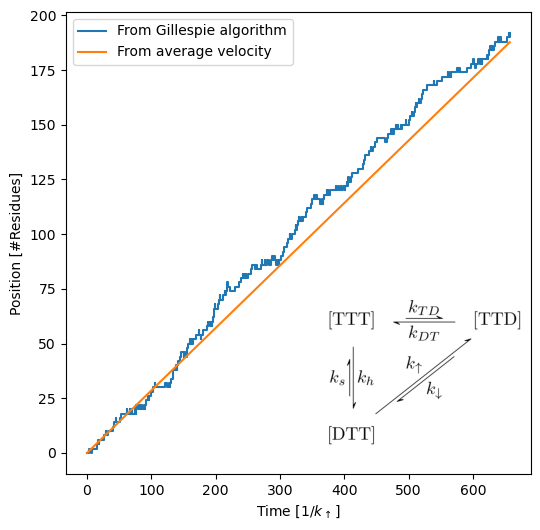

In [89]:
positions = SC_2RS_3_states.gillespie(positions=True)
fig, ax = SC_2RS_3_states.plot_position_evolution(
    positions, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2RS_kinetic_scheme.jpg"
    )
plt.show()

In [29]:
out = gillespie(SC_2RS_3_states_model, "TTT")
positions = compute_positions(out, transition_up=("DTT", "TTD"), transition_down=("TTD", "DTT"))

In [30]:
# Analytical average solutions

# Probability weights
p_TTT = k_s * k_DT + k_s * k_down + k_up * k_DT
p_DTT = k_h * k_down + k_down * k_TD + k_h * k_DT
p_TTD = k_up * k_TD + k_s * k_TD + k_h * k_up
normalization_factor = p_TTT + p_DTT + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_TTD /= normalization_factor

# Average velocity
SC_2RS_3_states_v = k_up * p_DTT - k_down * p_TTD # Sequential Clockwise/2-Residue Step, 3 states

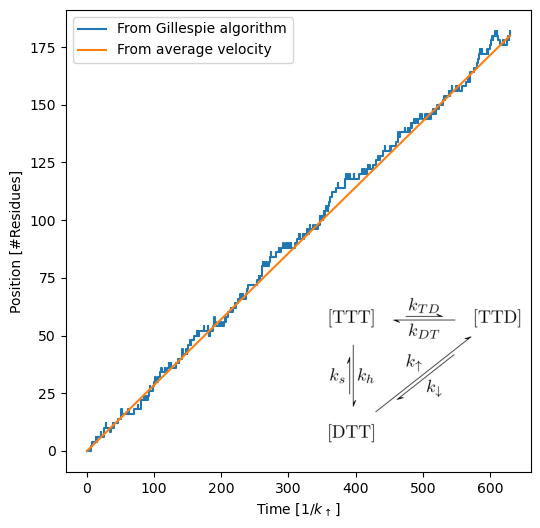

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
fig, ax = plot_position_evolution(positions, r"$1/k_\uparrow$", average_velocity=SC_2RS_3_states_v, 
                        kinetic_scheme_path="SC_2RS_kinetic_scheme.jpg", fig=fig, ax=ax)
plt.show()
if savefig:
    fig.savefig("SC_2RS_position_evolution.pdf", dpi=300, bbox_inches='tight')

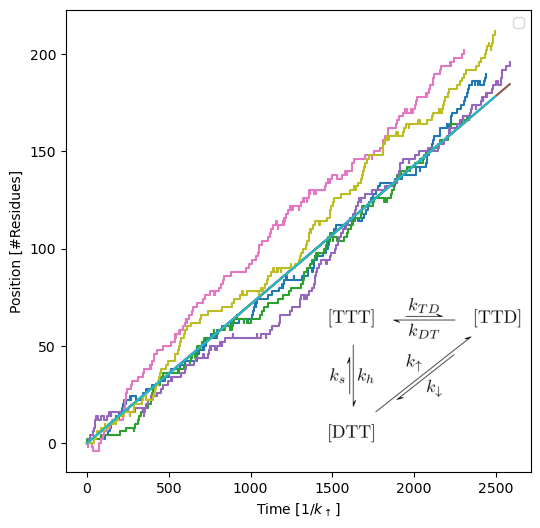

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
for _ in range(5):
    out = gillespie(model, "TTT")
    positions = compute_positions(out, transition_up=("DTT", "TTD"), transition_down=("TTD", "DTT"))
    fig, ax = plot_position_evolution(positions, r"$1/k_\uparrow$", average_velocity=v, 
                            kinetic_scheme_path="SC_2RS_kinetic_scheme.jpg", fig=fig, ax=ax)
ax.legend('')
plt.show()

### 4 states model

![](SC_2RS_4_states_kinetic_scheme.jpg)

In [127]:
# Protomer-ATP/ADP dissociation constants
# Main loop (1)
K_d_ATP_1 = 1
K_d_ADP_1 = 1
# Second loop (2)
K_d_ATP_2 = 1
K_d_ADP_2 = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
# Main loop
k_DT_1 = 1
# Constraint from ATP-ADP exchange model
k_TD_1 = k_DT_1 * K_d_ATP_1 / K_d_ADP_1 / ATP_over_ADP
# Second loop
k_DT_2 = 0.1
# Constraint from ATP-ADP exchange model
k_TD_2 = k_DT_2 * K_d_ATP_2 / K_d_ADP_2 / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
k_down = 0.1

# ATP/ADP hydrolysis/synthesis rates
# Main loop
k_h_1 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_1 = k_h_1 * k_up * k_DT_1 / (k_down * k_TD_1) * ATP_over_ADP_equilibrium / ATP_over_ADP
# Second loop
k_h_2 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_2 = k_h_2 * k_up * k_DT_2 / (k_down * k_TD_2) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Model
model = nx.DiGraph()
model.add_edges_from([
    ("TTT", "DTT", {'rate': k_h_1}), ("DTT", "TTT", {'rate': k_s_1}),
    ("DTT", "TTD", {'rate': k_up}), ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT_1}), ("TTT", "TTD", {'rate': k_TD_1}),
    ("TTD", "DTD", {'rate': k_h_2}), ("DTD", "TTD", {'rate': k_s_2}),
    ("DTD", "DTT", {'rate': k_DT_2}), ("DTT", "DTD", {'rate': k_TD_2})]
)

In [128]:
out = gillespie(model, "TTT")
positions = compute_positions(out, transition_up=("DTT", "TTD"), transition_down=("TTD", "DTT"))

In [129]:
# Analytical average solutions

# Probability weights
p_TTT = (k_s_1 * k_DT_1 * (k_DT_2 + k_s_2)
         + k_s_1 * (k_DT_2 * k_down + k_s_2 * k_down + k_DT_2 * k_h_2)
         + k_DT_1 * (k_up * k_s_2 + k_up * k_DT_2 + k_DT_2 * k_s_2))
p_DTT = (k_DT_2 * k_down * k_h_1
         + k_DT_2 * k_down * k_TD_1
         + k_down * k_h_1 * k_s_2
         + k_DT_2 * k_h_1 * (k_h_2 + k_DT_1)
         + k_DT_2 * k_h_2 * k_TD_1
         + k_down * k_s_2 * k_TD_1
         + k_h_1 * k_s_2 * k_DT_1)
p_DTD = (k_h_2 * k_TD_2 * (k_TD_1 + k_h_1)
         + k_h_2 * (k_TD_1 * k_up + k_h_1 * k_up + k_TD_1 * k_s_1)
         + k_TD_2 * (k_down * k_h_1 + k_down * k_TD_1 + k_DT_1 * k_h_1))
p_TTD = (k_TD_1 * k_up * k_s_2
         + k_TD_1 * k_up * k_DT_2
         + k_up * k_s_2 * k_h_1
         + k_TD_1 * k_s_2 * (k_s_1 + k_TD_2)
         + k_TD_1 * k_s_1 * k_DT_2
         + k_up * k_h_1 * k_DT_2
         + k_s_2 * k_h_1 * k_TD_2)
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

# Average velocity
v = k_up * p_DTT - k_down * p_TTD

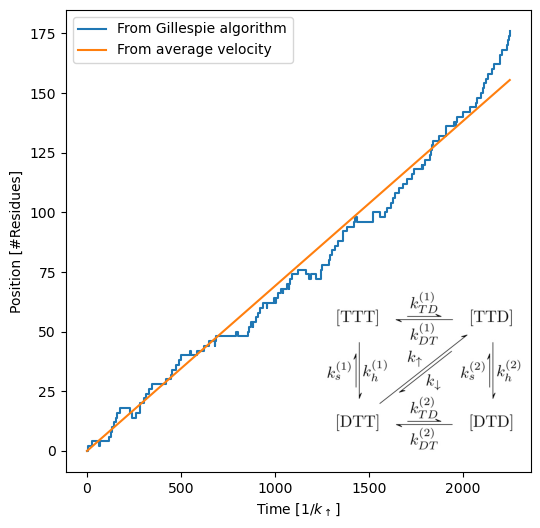

In [130]:
fig, ax = plot_position_evolution(positions, r"$1/k_\uparrow$", average_velocity=v, 
                        kinetic_scheme_path="SC_2RS_4_states_kinetic_scheme.jpg")
fig.savefig("SC_2RS_4_states_position_evolution.pdf", dpi=300, bbox_inches='tight')

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

In [131]:
# Protomer-ATP/ADP dissociation constants
K_d_ATP = 1
K_d_ADP = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# ATP/ADP hydrolysis/synthesis rates
k_bar_h = 0.1
k_s = 0.1

# Spiral-disc transitions in ATP mode
k_spiral_to_disc_up = 1
k_disc_to_spiral_down = 1

# Disc-spiral transitions in ADP mode
k_disc_to_spiral_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_spiral_to_disc_down = (k_bar_h * k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up
                         / (k_s * k_TD * k_disc_to_spiral_down)
                         * ATP_over_ADP_equilibrium / ATP_over_ADP)

# Model
model = nx.DiGraph()
model.add_edges_from([
    ("━━", "┉┉", {'rate': k_bar_h}), ("┉┉", "━━", {'rate': k_s}),
    ("┉┉", "┋", {'rate': k_disc_to_spiral_up}), ("┋", "┉┉", {'rate': k_spiral_to_disc_down}),
    ("┋", "┃", {'rate': k_DT}), ("┃", "┋", {'rate': k_TD}),
    ("┃", "━━", {'rate': k_spiral_to_disc_up}), ("━━", "┃", {'rate': k_disc_to_spiral_down})]
)

In [132]:
out = gillespie(model, "━━")
positions = compute_positions(out, transition_up=("┉┉", "┋"), transition_down=("┋", "┉┉"))

In [133]:
# Analytical average solutions

# Probability weights
p_disc_ATP = (k_s * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_s * k_DT * k_spiral_to_disc_up
              + k_s * k_spiral_to_disc_down * k_TD
              + k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up)
p_disc_ADP = (k_bar_h * k_spiral_to_disc_down * k_TD
              + k_bar_h * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_spiral_to_disc_down * k_TD * k_disc_to_spiral_down
              + k_bar_h * k_DT * k_spiral_to_disc_up)
p_spiral_ADP = (k_disc_to_spiral_up * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_TD
                + k_s * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_spiral_to_disc_up)
p_spiral_ATP = (k_s * k_DT * k_disc_to_spiral_down
                + k_disc_to_spiral_up * k_DT * k_disc_to_spiral_down
                + k_s * k_spiral_to_disc_down * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_DT)
normalization_factor = p_disc_ATP + p_disc_ADP + p_spiral_ADP + p_spiral_ATP
p_disc_ATP /= normalization_factor
p_disc_ADP /= normalization_factor
p_spiral_ADP /= normalization_factor
p_spiral_ATP /= normalization_factor

# Average velocity
v = k_disc_to_spiral_up * p_disc_ADP - k_spiral_to_disc_down * p_spiral_ADP

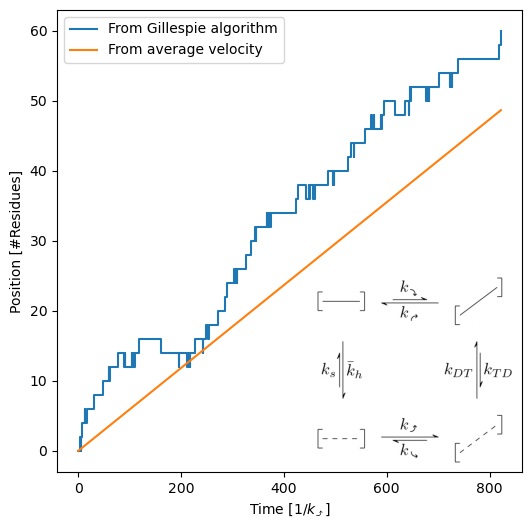

In [134]:
fig, ax = plot_position_evolution(positions, r"$1/k_⤴$", average_velocity=v, 
                        kinetic_scheme_path="Disc_spiral_kinetic_scheme.jpg")
fig.savefig("Disc_spiral_position_evolution.pdf", dpi=300, bbox_inches='tight')